# Face Recognition Model Benchmark — Results Analysis

This notebook loads the benchmark results from `results/benchmark_results.json` and provides interactive visualization.

In [1]:
import json
import subprocess
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Find project root via git
_root = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip())
RESULTS_PATH = _root / "results" / "benchmark_results.json"

with open(RESULTS_PATH) as f:
    results = json.load(f)

print(f"Loaded results for {len(results)} models: {list(results.keys())}")

Loaded results for 4 models: ['OpenCV SFace', 'AuraFace', 'DeepFace GhostFaceNet', 'Dlib ResNet-34']


## Summary Table

In [2]:
header = f"{'Model':<25} {'AUC':>8} {'EER':>8} {'TAR@1%':>10} {'TAR@0.1%':>10} {'Pairs':>7} {'Skip':>6} {'Fail%':>7}"
print(header)
print('-' * len(header))
for name, r in results.items():
    total = r['num_pairs'] + r['num_skipped']
    fail_rate = r['num_skipped'] / total if total > 0 else 0
    print(
        f"{name:<25} "
        f"{r['auc']:>8.4f} "
        f"{r['eer']:>8.4f} "
        f"{r['tar_at_far_001']:>10.4f} "
        f"{r['tar_at_far_0001']:>10.4f} "
        f"{r['num_pairs']:>7d} "
        f"{r['num_skipped']:>6d} "
        f"{fail_rate:>6.2%}"
    )

Model                          AUC      EER     TAR@1%   TAR@0.1%   Pairs   Skip   Fail%
----------------------------------------------------------------------------------------
OpenCV SFace                0.9957   0.0210     0.9680     0.9303    6000      0  0.00%
AuraFace                    0.9986   0.0103     0.9890     0.9473    5996      4  0.07%
DeepFace GhostFaceNet       0.9506   0.0988     0.8433     0.7753    6000      0  0.00%
Dlib ResNet-34              0.9993   0.0083     0.9920     0.9715    5176    824 13.73%


## ROC Curves (Linear Scale)

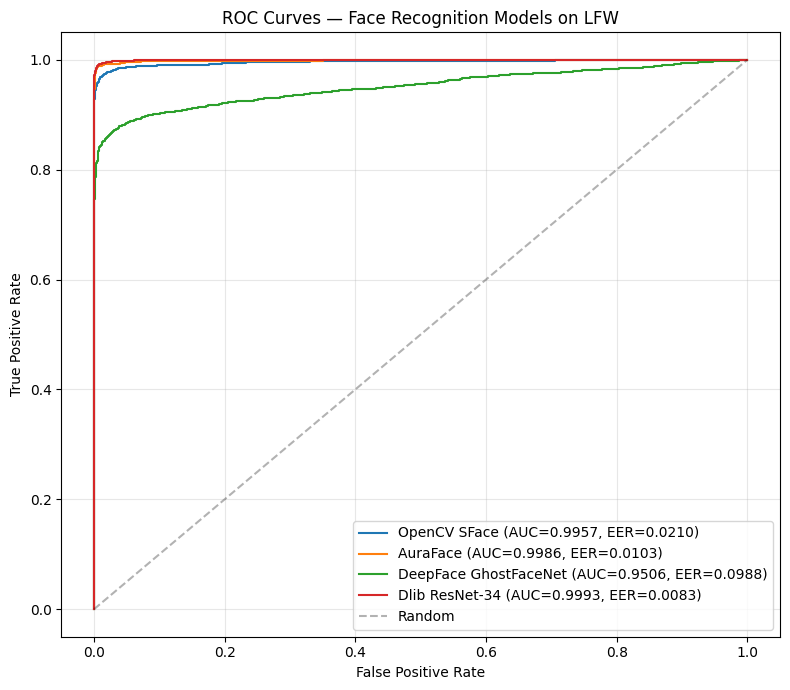

In [3]:
fig, ax = plt.subplots(figsize=(8, 7))
for name, r in results.items():
    fpr = np.array(r['fpr'])
    tpr = np.array(r['tpr'])
    if len(fpr) == 0:
        continue
    ax.plot(fpr, tpr, label=f"{name} (AUC={r['auc']:.4f}, EER={r['eer']:.4f})")

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves — Face Recognition Models on LFW')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

## ROC Curves (Log Scale)

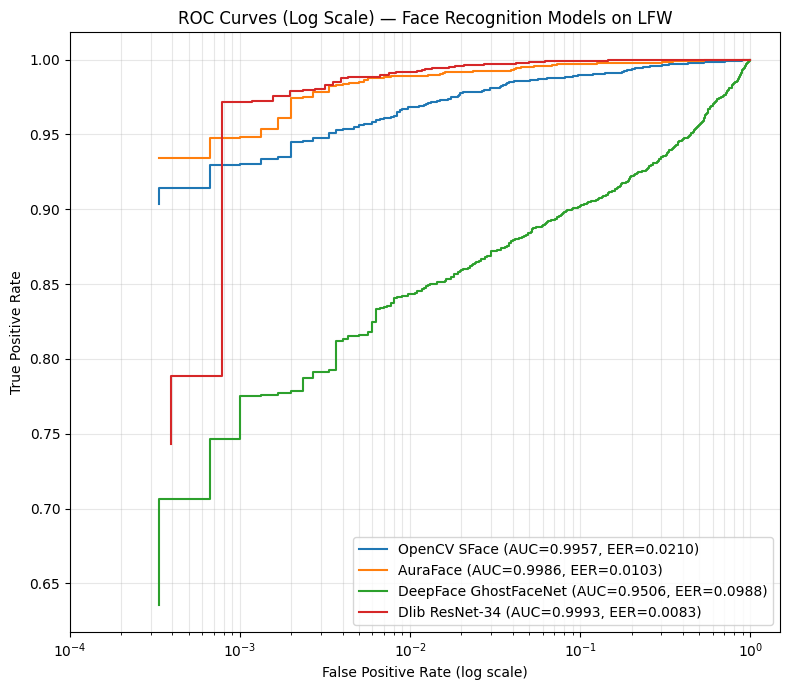

In [4]:
fig, ax = plt.subplots(figsize=(8, 7))
for name, r in results.items():
    fpr = np.array(r['fpr'])
    tpr = np.array(r['tpr'])
    if len(fpr) == 0:
        continue
    mask = fpr > 0
    ax.plot(fpr[mask], tpr[mask], label=f"{name} (AUC={r['auc']:.4f}, EER={r['eer']:.4f})")

ax.set_xscale('log')
ax.set_xlabel('False Positive Rate (log scale)')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves (Log Scale) — Face Recognition Models on LFW')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim(left=1e-4)
fig.tight_layout()
plt.show()

## Speed Comparison

In [5]:
# Speed summary table
timed = {name: r for name, r in results.items() if "timing" in r}

if not timed:
    print("No timing data available. Re-run the benchmark to collect speed measurements.")
else:
    header = f"{'Model':<25} {'Avg(ms)':>9} {'Med(ms)':>9} {'Std(ms)':>9} {'Setup(s)':>9} {'Total(s)':>9} {'Embeddings':>11}"
    print(header)
    print("-" * len(header))
    for name, r in timed.items():
        t = r["timing"]
        print(
            f"{name:<25} "
            f"{t['avg_embedding_time_ms']:>9.1f} "
            f"{t['median_embedding_time_ms']:>9.1f} "
            f"{t['std_embedding_time_ms']:>9.1f} "
            f"{t['setup_time_s']:>9.2f} "
            f"{t['total_eval_time_s']:>9.1f} "
            f"{t['num_timed_embeddings']:>11d}"
        )

Model                       Avg(ms)   Med(ms)   Std(ms)  Setup(s)  Total(s)  Embeddings
---------------------------------------------------------------------------------------
OpenCV SFace                    6.5       6.5       0.6      0.04      78.7       12000
AuraFace                       66.5      63.5      11.6      1.19     798.0       11992
DeepFace GhostFaceNet          51.5      51.0      10.9      4.53     618.7       12000
Dlib ResNet-34                  8.2       8.2       0.3      0.00      94.3       10352


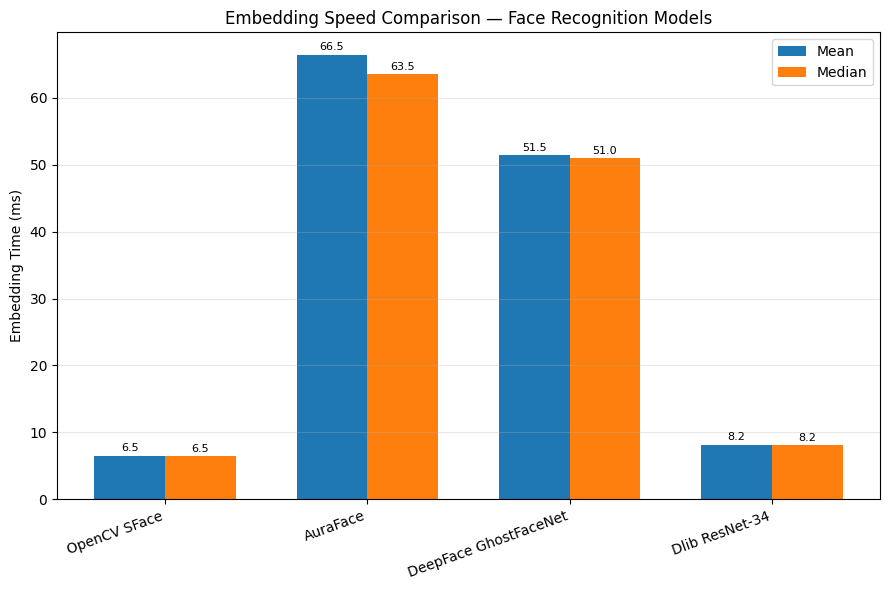

In [6]:
# Speed comparison bar chart
if timed:
    names = list(timed.keys())
    means = [timed[n]["timing"]["avg_embedding_time_ms"] for n in names]
    medians = [timed[n]["timing"]["median_embedding_time_ms"] for n in names]

    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9, 6))
    bars_mean = ax.bar(x - width / 2, means, width, label="Mean")
    bars_median = ax.bar(x + width / 2, medians, width, label="Median")

    ax.set_ylabel("Embedding Time (ms)")
    ax.set_title("Embedding Speed Comparison — Face Recognition Models")
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=20, ha="right")
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")

    for bar in bars_mean:
        h = bar.get_height()
        ax.annotate(f"{h:.1f}", xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3), textcoords="offset points", ha="center", fontsize=8)
    for bar in bars_median:
        h = bar.get_height()
        ax.annotate(f"{h:.1f}", xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3), textcoords="offset points", ha="center", fontsize=8)

    fig.tight_layout()
    plt.show()
else:
    print("No timing data — skipping speed chart.")

## RFW Race-Based Evaluation

Load RFW results (generated by `run_benchmark.py --rfw-dir`) and visualize per-race accuracy differences.

In [6]:
RFW_RESULTS_PATH = _root / "results" / "rfw_results.json"

if RFW_RESULTS_PATH.exists():
    with open(RFW_RESULTS_PATH) as f:
        rfw_results = json.load(f)
    races = list(rfw_results.keys())
    print(f"Loaded RFW results for {len(races)} races: {races}")

    # Summary table
    header = f"{'Race':<12} {'Model':<25} {'AUC':>8} {'EER':>8} {'TAR@1%':>10} {'TAR@0.1%':>10} {'Pairs':>7} {'Skip':>6}"
    print("\n" + header)
    print("-" * len(header))
    for race in races:
        for name, r in rfw_results[race].items():
            print(
                f"{race:<12} {name:<25} "
                f"{r['auc']:>8.4f} {r['eer']:>8.4f} "
                f"{r['tar_at_far_001']:>10.4f} {r['tar_at_far_0001']:>10.4f} "
                f"{r['num_pairs']:>7d} {r['num_skipped']:>6d}"
            )
else:
    rfw_results = None
    print("No RFW results found. Run: python scripts/run_benchmark.py --rfw-dir data/rfw")

Loaded RFW results for 4 races: ['Asian', 'Caucasian', 'Indian', 'African']

Race         Model                          AUC      EER     TAR@1%   TAR@0.1%   Pairs   Skip
---------------------------------------------------------------------------------------------
Asian        OpenCV SFace                0.9602   0.1022     0.7605     0.6004    5996      3
Asian        AuraFace                    0.9479   0.1261     0.6495     0.4051    5997      2
Asian        DeepFace GhostFaceNet       0.6984   0.3704     0.2337     0.0253    5999      0
Asian        Dlib ResNet-34              0.8402   0.2388     0.2356     0.1170    5380    619
Caucasian    OpenCV SFace                0.9824   0.0587     0.8702     0.7462    5997      2
Caucasian    AuraFace                    0.9828   0.0630     0.8089     0.6391    5997      2
Caucasian    DeepFace GhostFaceNet       0.7786   0.2839     0.4361     0.0840    5999      0
Caucasian    Dlib ResNet-34              0.9667   0.0975     0.6189     0.404

### ROC Curves by Race

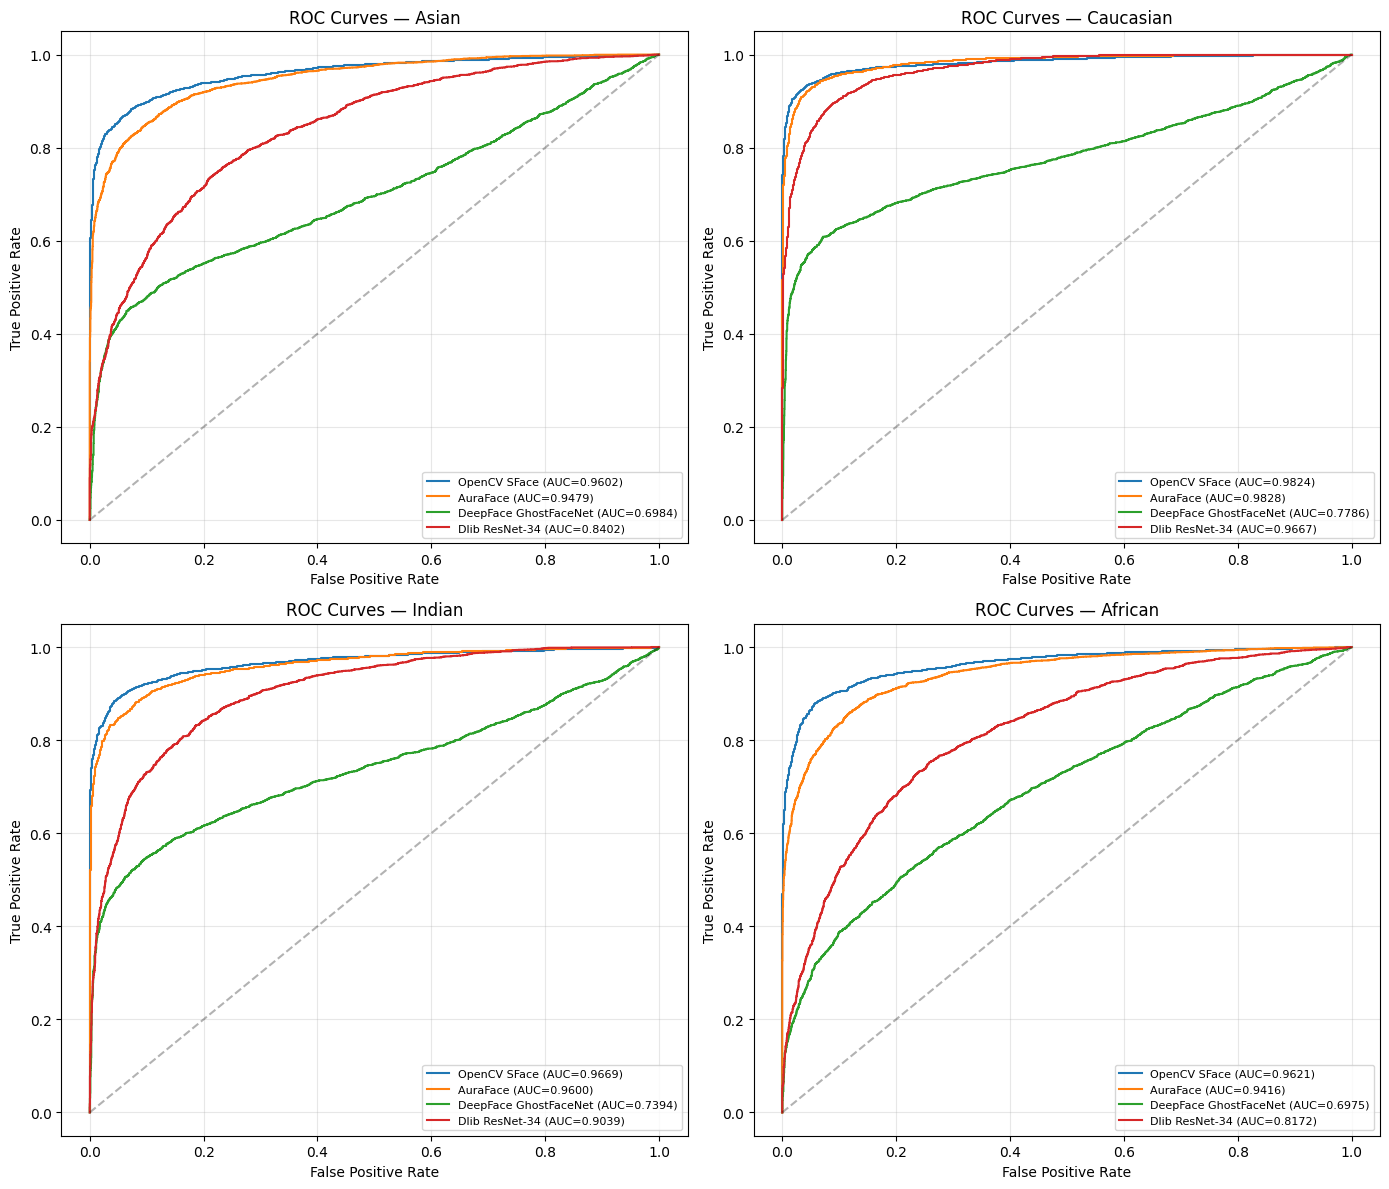

In [7]:
if rfw_results:
    races = list(rfw_results.keys())
    cols = 2
    rows = (len(races) + 1) // 2

    fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
    axes = np.array(axes).flatten()

    for i, race in enumerate(races):
        ax = axes[i]
        for name, r in rfw_results[race].items():
            fpr = np.array(r["fpr"])
            tpr = np.array(r["tpr"])
            if len(fpr) == 0:
                continue
            ax.plot(fpr, tpr, label=f"{name} (AUC={r['auc']:.4f})")
        ax.plot([0, 1], [0, 1], "k--", alpha=0.3)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"ROC Curves — {race}")
        ax.legend(loc="lower right", fontsize=8)
        ax.grid(True, alpha=0.3)

    for j in range(len(races), len(axes)):
        axes[j].set_visible(False)

    fig.tight_layout()
    plt.show()
else:
    print("No RFW results — skipping ROC curves by race.")

### AUC / EER Comparison Across Races

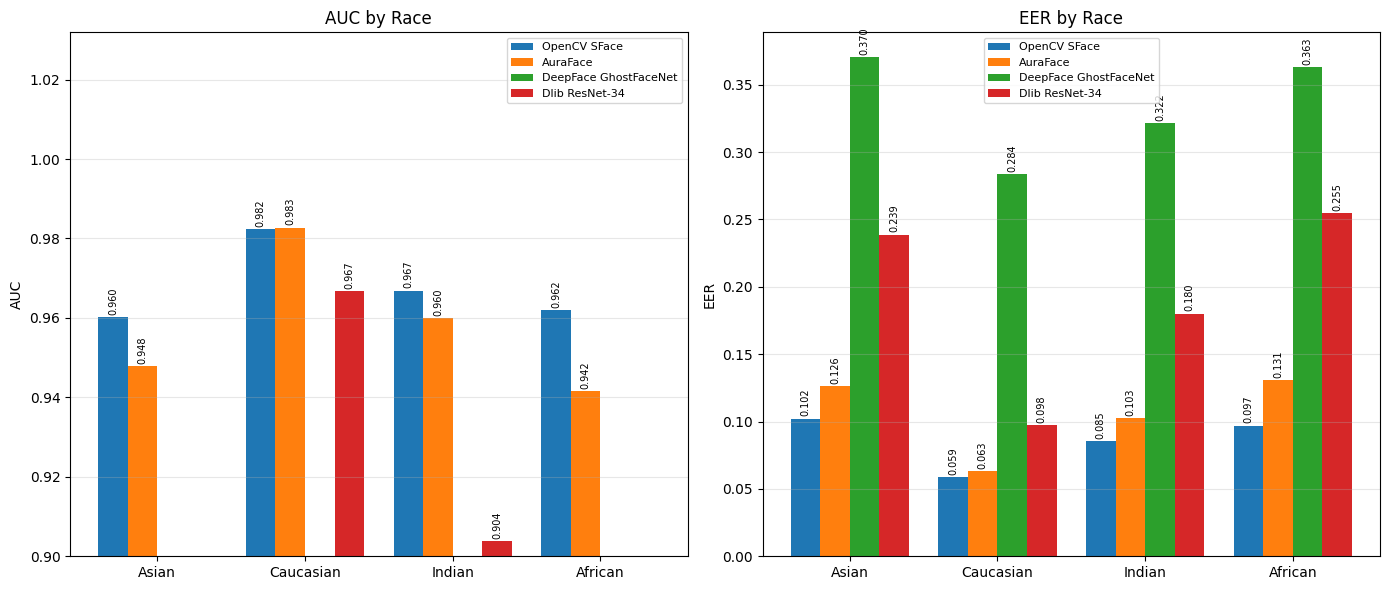

In [8]:
if rfw_results:
    races = list(rfw_results.keys())
    model_names = list(rfw_results[races[0]].keys())

    x = np.arange(len(races))
    n_models = len(model_names)
    width = 0.8 / n_models

    fig, (ax_auc, ax_eer) = plt.subplots(1, 2, figsize=(14, 6))

    for i, model_name in enumerate(model_names):
        aucs = [rfw_results[race].get(model_name, {}).get("auc", 0) for race in races]
        offset = (i - n_models / 2 + 0.5) * width
        bars = ax_auc.bar(x + offset, aucs, width, label=model_name)
        for bar in bars:
            h = bar.get_height()
            ax_auc.annotate(f"{h:.3f}", xy=(bar.get_x() + bar.get_width() / 2, h),
                            xytext=(0, 3), textcoords="offset points", ha="center", fontsize=7, rotation=90)

    ax_auc.set_ylabel("AUC")
    ax_auc.set_title("AUC by Race")
    ax_auc.set_xticks(x)
    ax_auc.set_xticklabels(races)
    ax_auc.legend(fontsize=8)
    ax_auc.grid(True, alpha=0.3, axis="y")
    ax_auc.set_ylim(bottom=0.9)

    for i, model_name in enumerate(model_names):
        eers = [rfw_results[race].get(model_name, {}).get("eer", 0) for race in races]
        offset = (i - n_models / 2 + 0.5) * width
        bars = ax_eer.bar(x + offset, eers, width, label=model_name)
        for bar in bars:
            h = bar.get_height()
            ax_eer.annotate(f"{h:.3f}", xy=(bar.get_x() + bar.get_width() / 2, h),
                            xytext=(0, 3), textcoords="offset points", ha="center", fontsize=7, rotation=90)

    ax_eer.set_ylabel("EER")
    ax_eer.set_title("EER by Race")
    ax_eer.set_xticks(x)
    ax_eer.set_xticklabels(races)
    ax_eer.legend(fontsize=8)
    ax_eer.grid(True, alpha=0.3, axis="y")

    fig.tight_layout()
    plt.show()
else:
    print("No RFW results — skipping metric comparison.")